In [9]:
import numpy as np
import pandas as pd
import math
from functools import reduce
import random
random.seed(2010)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Tahoma']})
rc('text', usetex=True)




def cost_iterator(i,cost_func,my_dict):
    for k,v in my_dict.items():
        yield cost_func(k,i,v)
        
def MakeDiagram(data_location,list_of_funcs,range_for_x = np.linspace(1.02,3,97),
               title = "",x_label = "", y_label = "", line_parameters = [],additional_functions = []):
    global global_observation_list
    val_dict = {}    
    n = 0
    mean = 1    
    with open(data_location,'r') as f:
        for line in f:
            v1,v2 = line.split(',')
            a = int(v1) # Count of Edges
            i = int(v2) # Count of Nodes w/ a edges
            if a<1:
                continue
            n+=i
            mean+=i*a
            val_dict[a] = i
    mean = mean/n
    assert(mean>1)    
    alpha = (2*mean-1)/(mean-1)
    print("alpha = {}".format(alpha))
    
    X = range_for_x
    list_Y = []
    for _ in range(len(list_of_funcs)):
        list_Y.append([])
    for i in X:
        global_observation_list = None
        for j in range(len(list_of_funcs)):
            list_Y[j].append(list_of_funcs[j](alpha,val_dict,i,n))
    for func in additional_functions:
        func()            
    if len(list_Y) == len(line_parameters):
        for i in range(len(list_Y)):
            if line_parameters[i][0] is None:
                plt.plot(X,list_Y[i],label=line_parameters[i][1])
            else:
                plt.plot(X,list_Y[i],line_parameters[i][0],label=line_parameters[i][1],markevery = 10)
        plt.legend(fontsize = 12)
            
    else:        
        for Y in list_Y:
            plt.plot(X,Y)
    if title:
        plt.title(title, fontsize=14)
    if x_label:
        plt.xlabel(x_label, fontsize=18)
    if y_label:
        plt.ylabel(y_label, fontsize=18)
#plt.show()
#plt.savefig('results/ungraph_occupancy.png')    
    
def setAxLinesBW(ax):
    """
    Take each Line2D in the axes, ax, and convert the line style to be 
    suitable for black and white viewing.
    """
    MARKERSIZE = 3

    COLORMAP = {
        'b': {'marker': None, 'dash': (None,None)},
        'g': {'marker': None, 'dash': [5,5]},
        'r': {'marker': None, 'dash': [5,3,1,3]},
        'c': {'marker': None, 'dash': [1,3]},
        'm': {'marker': None, 'dash': [5,2,5,2,5,10]},
        'y': {'marker': None, 'dash': [5,3,1,2,1,10]},
        'k': {'marker': 'o', 'dash': (None,None)} #[1,2,1,10]}
        }


    lines_to_adjust = ax.get_lines()
    try:
        lines_to_adjust += ax.get_legend().get_lines()
    except AttributeError:
        pass

    for line in lines_to_adjust:
        origColor = line.get_color()
        line.set_color('black')
        line.set_dashes(COLORMAP[origColor]['dash'])
        line.set_marker(COLORMAP[origColor]['marker'])
        line.set_markersize(MARKERSIZE)

def setFigLinesBW(fig):
    """
    Take each axes in the figure, and for each line in the axes, make the
    line viewable in black and white.
    """
    for ax in fig.get_axes():
        setAxLinesBW(ax)


In [10]:
def cost_powers_k(rv, k, count):
    assert(k!=1)
    power = math.ceil(math.log(rv, k))
    cutoff = k**power
    space_cost = math.floor(cutoff)-rv
    time_cost = sum_cutoff(k,power)
    #time_cost = (cutoff - 1)*1.0/(k-1)
    return (count*space_cost,count*time_cost,count*rv)

def sum_cutoff(k,power):
    prev_V = 1
    prev_V_rounded = 1
    V = 1
    S = 1
    i = 1
    for i in range(power-1):
        prev_V *= k        
        V = math.floor(prev_V)
        if prev_V_rounded == V:
            continue
        prev_V_rounded = V
        S+=V
    return S


def sum_pair_costs(iterator, n):
    sum1,sum2,sum3 = reduce(lambda x,y : (x[0]+y[0],x[1]+y[1],x[2]+y[2]),\
                                        iterator,(0,0,0))
    return (sum1/n,sum2/n,sum3/n)

global_observation_list = None
beta = .1
def memory_overhead(_, val_dict, i, n):
    global global_observation_list    
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_dict),n)
    return global_observation_list[0]
def computation_overhead (_, val_dict, i, n):
    global global_observation_list
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_dict),n)
    return global_observation_list[1]
def mean (_, val_dict, i, n):
    global global_observation_list
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_dict),n)
    return global_observation_list[2]
def occupancy (_, val_dict, i, n):
    global global_observation_list
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_dict),n)
    return global_observation_list[2]/(global_observation_list[0]+global_observation_list[2])
def cost (_, val_dict, i, n):
    global global_observation_list
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_array),n)
    return global_observation_list[0] + beta*global_observation_list[1]

estimated_occupancy = lambda a,_,i,n : ((1-a)/(2-a))*(1-(i-1)/(i-i**(2-a)))
estimated_memory = lambda a,_,i,n :  (i-1)/(1-i**(2-a)) + 1/(2-a)
estimated_mean = lambda a,_,i,n : (a-1)/(a-2)
estimated_computation = lambda a,_,i,n :  1/(1-i**(2-a))
estimated_cost = lambda a,_,i,n :  estimated_memory(a,_,i,n) + beta*estimated_computation(a,_,i,n)

cost_derivative = lambda a,b: lambda x : (\
                         1+(1-a)*x**(2-a)+(b*(2-a)-2+a)*(x)**(1-a)
                        )/((1-x**(2-a))**2)
reduced_cost_derivative = lambda a,b: lambda x : 1+(1-a)*x**(2-a)\
                                             +((b-1)*(2-a))*(x)**(1-a)

alpha = 2.0237927571316328


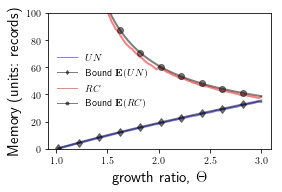

In [56]:
# data_location,list_of_funcs,range_for_x = np.linspace(1.02,3,100),
#               title = "",x_label = "", y_label = "", line_parameters = [],additional_functions = []
data_location = 'resources/data/com-orkut.ungraphcounts.txt'
list_of_funcs =  [memory_overhead,estimated_memory,computation_overhead,estimated_computation]
title = "Orkut Memory Computation Trade Off"
x_label = 'growth ratio, $\Theta$'
y_label = 'Memory (units: records)'
LineParams  = [
    ['-b',r'$UN$'],
    ['-dk',r'Bound $\mathbf{E}({UN})$'],    
    ['-r',r'$RC$'],
    ['-ok',r'Bound $\mathbf{E}(RC)$']]
additional_functions = [lambda ax : ax.set_ylim(0,100)]
X = list(np.linspace(1.02,3,100))
fig = MakeDiagram2(data_location,list_of_funcs,range_for_x = X, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
fig.savefig("LiveGraphResults/Orkut_comp.pdf",bbox_inches='tight')


alpha = 2.071866259416793


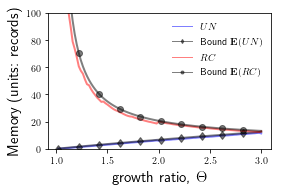

In [55]:
data_location = 'resources/data/soc-LiveJournal1counts.txt'
list_of_funcs =  [memory_overhead,estimated_memory,computation_overhead,estimated_computation]
title = "LiveJournal Memory Computation Trade Off"
x_label = 'growth ratio, $\Theta$'
y_label = 'Memory (units: records)'
LineParams  = [
    ['-b',r'$UN$'],
    ['-dk',r'Bound $\mathbf{E}({UN})$'],    
    ['-r',r'$RC$'],
    ['-ok',r'Bound $\mathbf{E}(RC)$']]
additional_functions = [lambda ax : ax.set_ylim(0,100)]
X = list(np.linspace(1.02,3,100))
fig = MakeDiagram2(data_location,list_of_funcs,range_for_x = X, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
fig.savefig("LiveGraphResults/LiveJournal_comp.pdf",bbox_inches='tight')


alpha = 2.028078380403372


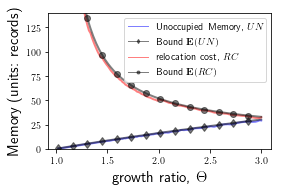

In [67]:
data_location = 'resources/data/twitter-2010_C0_COUNTS/part-00000-98beda5b-e9b1-4f0a-91d7-4984958ebb0c-c000.csv'
list_of_funcs =  [memory_overhead,estimated_memory,computation_overhead,estimated_computation]
title = "Twitter Memory Computation Trade Off"
x_label = 'growth ratio, $\Theta$'
y_label = 'Memory (units: records)'
LineParams  = [
    ['-b',r'Unoccupied Memory, $UN$'],
    ['-dk',r'Bound $\mathbf{E}({UN})$'],    
    ['-r',r'relocation cost, $RC$'],
    ['-ok',r'Bound $\mathbf{E}(RC)$']]
additional_functions = [lambda ax : ax.set_ylim(0,140)]#[lambda : plt.ylim(0,150),lambda : plt.y]
X = list(np.linspace(1.02,3,140))
fig = MakeDiagram2(data_location,list_of_funcs,range_for_x = X, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
fig.savefig("LiveGraphResults/Twitter_comp.pdf",bbox_inches='tight')


alpha = 2.066606331495111


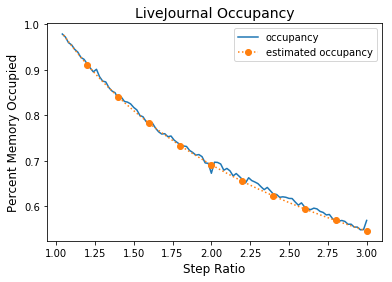

In [3]:
data_location = 'data/soc-LiveJournal1counts.txt'
list_of_funcs =  [occupancy,estimated_occupancy]
title = "LiveJournal Occupancy"
x_label = 'Step Ratio'
y_label = 'Percent Memory Occupied'
LineParams  = [[None,'occupancy'],[':o','estimated occupancy']]
additional_functions = []
x_range = []
for j in range(99):
    x_range.append(3-j*.02)
MakeDiagram(data_location,list_of_funcs, range_for_x=x_range, title = title, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
plt.show()

alpha = 2.0237927571316328


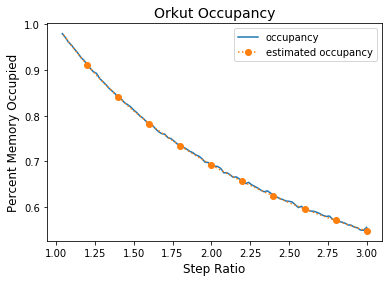

In [4]:
data_location = 'data/com-orkut.ungraphcounts.txt'
list_of_funcs =  [occupancy,estimated_occupancy]
title = "Orkut Occupancy"
x_label = 'Step Ratio'
y_label = 'Percent Memory Occupied'
LineParams  = [[None,'occupancy'],[':o','estimated occupancy']]
additional_functions = []
x_range = []
for j in range(99):
    x_range.append(3-j*.02)
MakeDiagram(data_location,list_of_funcs, range_for_x=x_range, title = title, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
plt.show()

alpha = 2.028078380403372


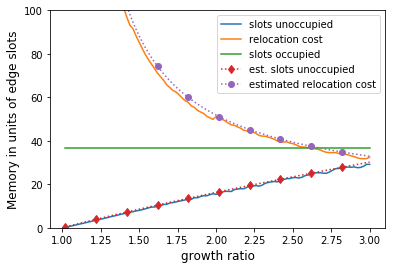

In [20]:
data_location = 'data/TwitterEdgeCounts.txt'
title = "Twitter Memory Computation Trade Off"
list_of_funcs =  [memory_overhead,computation_overhead,mean,estimated_memory,estimated_computation]
x_label = 'growth ratio'
y_label = 'Memory in units of edge slots'
LineParams  = [[None,'slots unoccupied'],[None,'relocation cost'],[None,'slots occupied'],
                    [':d','est. slots unoccupied'],[':o','estimated relocation cost']]
additional_functions = [lambda : plt.ylim(0,100)]
X = list(np.linspace(1.02,3,100))
fig = MakeDiagram2(data_location,list_of_funcs, range_for_x = X, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
fig.save

In [9]:
np.linspace(1.02,3,97)

array([1.02    , 1.040625, 1.06125 , 1.081875, 1.1025  , 1.123125,
       1.14375 , 1.164375, 1.185   , 1.205625, 1.22625 , 1.246875,
       1.2675  , 1.288125, 1.30875 , 1.329375, 1.35    , 1.370625,
       1.39125 , 1.411875, 1.4325  , 1.453125, 1.47375 , 1.494375,
       1.515   , 1.535625, 1.55625 , 1.576875, 1.5975  , 1.618125,
       1.63875 , 1.659375, 1.68    , 1.700625, 1.72125 , 1.741875,
       1.7625  , 1.783125, 1.80375 , 1.824375, 1.845   , 1.865625,
       1.88625 , 1.906875, 1.9275  , 1.948125, 1.96875 , 1.989375,
       2.01    , 2.030625, 2.05125 , 2.071875, 2.0925  , 2.113125,
       2.13375 , 2.154375, 2.175   , 2.195625, 2.21625 , 2.236875,
       2.2575  , 2.278125, 2.29875 , 2.319375, 2.34    , 2.360625,
       2.38125 , 2.401875, 2.4225  , 2.443125, 2.46375 , 2.484375,
       2.505   , 2.525625, 2.54625 , 2.566875, 2.5875  , 2.608125,
       2.62875 , 2.649375, 2.67    , 2.690625, 2.71125 , 2.731875,
       2.7525  , 2.773125, 2.79375 , 2.814375, 2.835   , 2.855

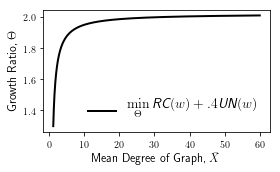

In [52]:
import math
from scipy.optimize import fsolve

reduced_cost_derivative = lambda a,b: lambda x : 1+(1-a)*x**(2-a)\
                                             +((b-1)*(2-a))*(x)**(1-a)
beta = .4
initial_guess = 1.5
Y = []
Y2 = []
Y3 = []
X = np.linspace(1.2,60,20000)
for m in X:
    alpha = (2*m-1)/(m-1) 
    result = fsolve(reduced_cost_derivative(alpha,beta), initial_guess)[0]
    Y.append(result)
'''    result = fsolve(reduced_cost_derivative(alpha,beta2), initial_guess)[0]
    Y2.append(result)
    result = fsolve(reduced_cost_derivative(alpha,beta3), initial_guess)[0]
    Y3.append(result)
''' 


val_dict = {}
params = {'legend.fontsize': 15,
          'lines.linewidth': 1,
          'pdf.fonttype': 42}
plt.rcParams.update(params)

fig, ax = plt.subplots()

fig.set_size_inches(4, 2.5)
fig.subplots_adjust(hspace = 0)
    
ax.plot(X,Y,'-k', linewidth =2,label=r'$\min\limits_{{\Theta}} \textit{{RC}}(w)+.4\textit{{UN}}(w)$')

legend = ax.legend(fontsize = 14,loc = 0, frameon=False)
            

ax.set_xlabel(r"Mean Degree of Graph, $\bar{{X}}$",fontsize = 12)
ax.set_ylabel(r"Growth Ratio, $\Theta$", fontsize= 12)
fig.tight_layout()
fig.savefig("LiveGraphResults/optimal_growth_ratio.pdf",bbox_inches='tight')



In [68]:
#!/usr/bin/env python3


#latency_corun = [0.164245, 0.237357, 0.436652, 0.641406, 0.775183, 0.880378]
#latency_alone = [0.085618, 0.102867, 0.155946, 0.209481, 0.26169, 0.284247]

#time_pagerank = [11.252377, 12.556378, 13.143194, 13.312559, 13.461941, 13.500465]


def MakeDiagram2(data_location,list_of_funcs,range_for_x = np.linspace(1.02,3,97),
               title = "",x_label = "", y_label = "", line_parameters = [],additional_functions = []):
    global global_observation_list
    val_dict = {}
    params = {'legend.fontsize': 15,
              'lines.linewidth': 1,
              'pdf.fonttype': 42}
    plt.rcParams.update(params)

    fig, ax = plt.subplots()

    fig.set_size_inches(4, 2.5)
    fig.subplots_adjust(hspace = 0)
    
    n = 0
    mean = 1    
    with open(data_location,'r') as f:
        for line in f:
            v1,v2 = line.split(',')
            a = int(v1) # Count of Edges
            i = int(v2) # Count of Nodes w/ a edges
            if a<1:
                continue
            n+=i
            mean+=i*a
            val_dict[a] = i
    mean = mean/n
    assert(mean>1)    
    alpha = (2*mean-1)/(mean-1)
    print("alpha = {}".format(alpha))
    
    X = range_for_x
    list_Y = []
    for _ in range(len(list_of_funcs)):
        list_Y.append([])
    for i in X:
        global_observation_list = None
        for j in range(len(list_of_funcs)):
            list_Y[j].append(list_of_funcs[j](alpha,val_dict,i,n))
    for func in additional_functions:
        func(ax)            
    if len(list_Y) == len(line_parameters):
        for i in range(len(list_Y)):
            if line_parameters[i][0] is None:
                ax.plot(X,list_Y[i],label=line_parameters[i][1],color = 'black')
            else:
                ax.plot(X,list_Y[i],line_parameters[i][0],alpha= .5, linewidth =2,label=line_parameters[i][1],markevery = 10)
                
        legend = ax.legend(fontsize = 10,loc = 0, frameon=True)
        for legend_handle in legend.legendHandles:
            legend_handle.set_linewidth(1.0)
            legend_handle._legmarker.set_markersize(3)
            
    else:        
        for Y in list_Y:
            plt.plot(X,Y)
    
    if title:
        fig.title(title, fontsize=14)
    if x_label:
        ax.set_xlabel(x_label, fontsize=15)
    if y_label:
        ax.set_ylabel(y_label, fontsize=15)
    return fig
#plt.show()
#plt.savefig('results/ungraph_occupancy.png')    
    
    


'''
legend = ax.legend(loc='center right')
for legend_handle in legend.legendHandles:
    legend_handle.set_linewidth(1.0)
    legend_handle._legmarker.set_markersize(3)
    legend_handle.set_
'''

#ax_label = ax.twinx()
#ax_label.set_yticks([])
#ax_label.set_ylabel(legendAsLatex(ax))

#ax2_label = ax2.twinx()
#ax2_label.set_yticks([])
#ax2_label.set_ylabel(legendAsLatex(ax2))

#ax2.set_ylabel('/\substack'+legendAsLatex(ax)) 

#ax2.plot([1, 2, 4, 8, 16, 32], LiveGraph['seek'], '-o', color='grey', markerfacecolor='none', label='PageRank')
# ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax2.set_xticklabels(['', '40K', '80K', '160K', '320K', '640K', '1.28M', ''], fontsize=15)
#legendAsLatex(ax2)
'''
legend = ax2.legend(loc='lower center')
for legend_handle in legend.legendHandles:
    legend_handle.set_linewidth(1.0)
    legend_handle._legmarker.set_markersize(3)
'''
# legend = ax.legend(loc='lower right')
# for legend_handle in legend.legendHandles:
#     legend_handle._legmarker.set_markersize(3)


fig.tight_layout()

#fig.savefig('microbenchmarking.pdf')

